<a href="https://colab.research.google.com/github/gagan3012/gsoc-ml/blob/master/Test_II_Learning_the_DM_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import random

In [2]:
!git clone https://github.com/ML4SCI/ML4SCI_GSoC

Cloning into 'ML4SCI_GSoC'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 21), reused 46 (delta 13), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [3]:
fname = '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/lenses.tgz'
extract_path = '/content'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()

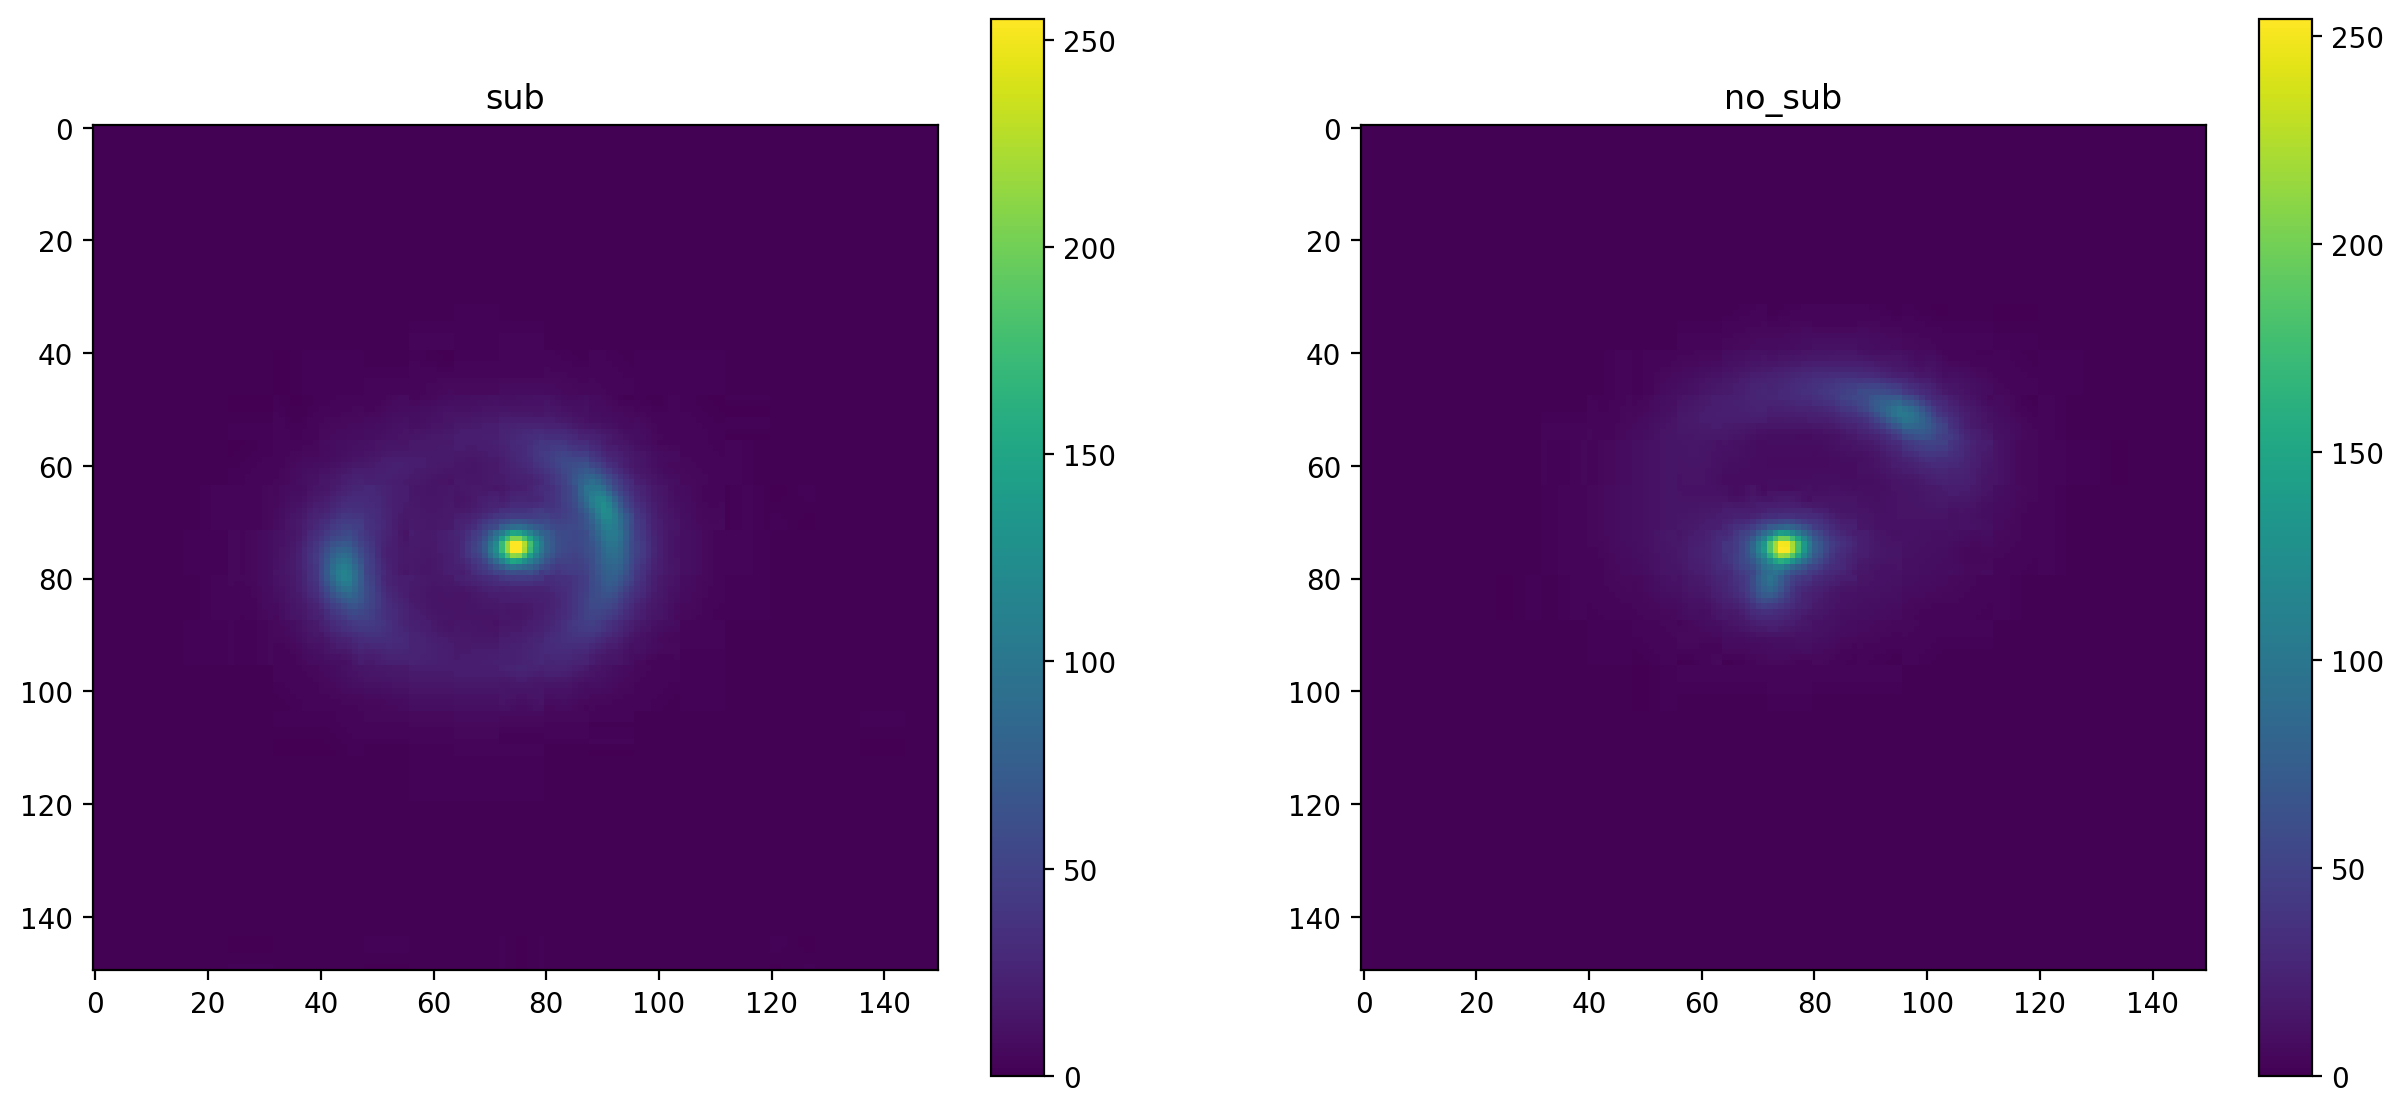

In [4]:
lenses_dir = '/content/lenses'

sub_dir = os.path.join(lenses_dir, 'sub')
no_sub_dir = os.path.join(lenses_dir, 'no_sub')

# Ploting random images 
sub_img = PIL.Image.open(os.path.join(sub_dir,random.choice(os.listdir(sub_dir))))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,random.choice(os.listdir(no_sub_dir))))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

In [5]:
dataset = ImageFolder(lenses_dir)

In [6]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


In [ ]:
class LensDataset(Dataset):
    def __init__(self, dataset, phase='train'):
        self.dataset = dataset
        self.phase = phase

    def __getitem__(self, idx):
        if self.phase == 'train':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomRotation(5),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.Resize((150, 150)),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            return data

        elif self.phase == 'eval':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Resize((150, 150)),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            label = dataset[idx][1]
            return data, label

    def __len__(self):
        return len(dataset)

In [8]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [9]:
BATCH_SIZE = 64

train_dataset = LensDataset(train_dataset, 'train')
test_dataset = LensDataset(test_dataset, 'eval')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# AAE 

In [10]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):

        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):

        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):

    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)
        return disc

In [11]:
class AAE(object):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def __init__(self):
        """
        Instanciates the models without prior training
        """
        print('using device:', AAE.device)

        encoder = Encoder()
        decoder = Decoder()
        discriminator = Discriminator()

        self.encoder = encoder.to(AAE.device)
        self.decoder = decoder.to(AAE.device)
        self.discriminator = discriminator.to(AAE.device)

    def load_model(self, encoder_model, decoder_model, discriminator_model):
        """
        Loads the model by being given the path to the architecture + weights of each network
        """
        encoder = torch.load(encoder_model, map_location=AAE.device)
        decoder = torch.load(decoder_model, map_location=AAE.device)
        discriminator = torch.load(discriminator_model, map_location=AAE.device)

        self.encoder = encoder.to(AAE.device)
        self.decoder = decoder.to(AAE.device)
        self.discriminator = discriminator.to(AAE.device)

    def train(self, train_dataloader, epochs, save_path):
        """
        Train the AAE.

        Inputs:
        -------
        train_dataloader: a `DataLoader` based on a `LensDataset`

        epochs: number of epochs to train on (int)

        save_path: path to save the model's weights and history (str)
        """
        # --- HYPERPARAMETERS --- (this could be made into a single method where you can input the desired hyperparams)
        # reconstruction phase:
        reconstruction_criterion = nn.MSELoss()
        encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=1e-4)
        decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=1e-4)

        # regularization phase:
        def discriminator_criterion(input, target, epsilon):
            return -torch.mean(torch.log(target + epsilon) + torch.log(1 - input + epsilon))

        def generator_criterion(input, epsilon):
            return -torch.mean(torch.log(input + epsilon))

        discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=1e-4)
        generator_optimizer = optim.Adam(self.encoder.parameters(), lr=1e-5)

        # --- HISOTRY ---
        history = {'reconstruction_losses': [],
                   'discriminator_losses': [],
                   'generator_losses': []}

        # --- TRAINING LOOP ---
        epsilon = 1e-10 # prevents the loss from getting to zero

        reconstruction_losses = []
        discriminator_losses = []
        generator_losses = []

        for epoch in range(epochs):
            self.decoder.train()
            self.encoder.train()
            self.discriminator.train()

            running_reconstruction_loss = 0.0
            running_discriminator_loss = 0.0
            running_generator_loss = 0.0

            loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
            for data in loop:
                data = data.to(AAE.device)

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                discriminator_optimizer.zero_grad()
                generator_optimizer.zero_grad()

                # RECONSTRUCTION PHASE
                # pass data through the autoencoder
                z_sample = self.encoder(data)
                x_sample = self.decoder(z_sample)

                # compute the loss
                reconstruction_loss = reconstruction_criterion(input=x_sample, target=data)
                
                # backpropagate and update weights
                reconstruction_loss.backward()
                decoder_optimizer.step()
                encoder_optimizer.step()

                # REGULARIZATION PHASE - DISCRIMINATOR
                self.encoder.eval()
                
                # generate target latent space data according to a gaussian distribution
                z_real_gauss = Variable(torch.randn(data.size(0), 1000) * 5.) # 1000 fixed cuz its the encoder's input size
                z_real_gauss = z_real_gauss.to(AAE.device) # what we want
                z_fake_gauss = self.encoder(data) # what we currently have

                # determine discriminator classification of both samples
                d_real_gauss = self.discriminator(z_real_gauss) # real sampled gaussian 
                d_fake_gauss = self.discriminator(z_fake_gauss) # fake created gaussian

                # compute the loss
                discriminator_loss = discriminator_criterion(input=d_fake_gauss, target=d_real_gauss, epsilon=epsilon)
                
                # backpropagate and update weights
                discriminator_loss.backward()
                discriminator_optimizer.step()

                # REGULARIZATION PHASE - GENERATOR
                self.encoder.train()

                z_fake_gauss = self.encoder(data)
                d_fake_gauss = self.discriminator(z_fake_gauss)
                
                # compute the loss
                generator_loss = generator_criterion(input=d_fake_gauss, epsilon=epsilon)

                # backpropagate and update weights
                generator_loss.backward()
                generator_optimizer.step()

                # STATS
                running_reconstruction_loss += reconstruction_loss.item() * data.size(0)
                running_discriminator_loss += discriminator_loss.item() * data.size(0)
                running_generator_loss += generator_loss.item() * data.size(0)

                loop.set_description(f'Epoch {epoch+1}/{epochs}')

            epoch_reconstruction_loss = running_reconstruction_loss / len(train_dataloader.dataset)
            epoch_discriminator_loss = running_discriminator_loss / len(train_dataloader.dataset)
            epoch_generator_loss = running_generator_loss / len(train_dataloader.dataset)

            reconstruction_losses.append(epoch_reconstruction_loss)
            discriminator_losses.append(epoch_discriminator_loss)
            generator_losses.append(epoch_generator_loss)

            print(f'\n[Epoch {epoch+1}/{epochs}]', 'reconstruction loss: {:.4f}; discriminator loss: {:.4f}; generator loss: {:.4f}'.format(epoch_reconstruction_loss, epoch_discriminator_loss, epoch_generator_loss))

        history['reconstruction_losses'] = reconstruction_losses
        history['discriminator_losses'] = discriminator_losses
        history['generator_losses'] = generator_losses

        torch.save({'encoder_weights': self.encoder.state_dict(),
                    'decoder_weights': self.decoder.state_dict(),
                    'discriminator_weights': self.discriminator.state_dict(),
                    'history': history}, save_path)
        
        self.history = history
        
    def metrics(self):
        """
        Plot the three metrics that are tracked during training.
        """
        fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

        epochs = len(self.history['reconstruction_losses'])

        axs[0].plot(range(1, epochs+1), self.history['reconstruction_losses'])
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Reconstruction loss')
        axs[0].set_title('Reconstruction loss')

        axs[1].plot(range(1, epochs+1), self.history['discriminator_losses'])
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Discriminator loss')
        axs[1].set_title('Discriminator loss')

        axs[2].plot(range(1, epochs+1), self.history['generator_losses'])
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Generator loss')
        axs[2].set_title('Generator loss')      
        
        plt.show()

    def evaluate(self, test_dataloader, thresh, find_thresh):
        """
        Use the AAE for inference over the `test_dataloader` data. A label is assigned 
        depending on whether the anomaly_score, defined as the error between the original
        image and its reconstruction, is above or below `thresh`.

        Inputs:
        -------
        test_dataloader: a `DataLoader` based on a `LensDataset`

        thresh: a number that defines the label of an input image according to the error
        between the original image and its reconstruction. If error > thresh, label = 1; 
        if error <= thresh, label = 0 (float)

        find_thresh: prints statistics related to the error scores. The mean of the
        mean error for each label is then used to obtain the value for `thresh` (bool)
        """
        self.encoder.eval()
        self.decoder.eval()
        self.discriminator.eval()

        anomaly_scores = {0:[], 1:[]}
        mse = nn.MSELoss()

        if find_thresh:
            print('\nfinding anomaly_scores statistics... use this to define `thresh`!')
            loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
            for data, label in loop:
                data = data.to(AAE.device)
                label = label.to(AAE.device)

                G = self.encoder(data)
                #D = self.discriminator(G)
                D = self.decoder(G)

                for i in range(data.shape[0]):
                    #anomaly_score = torch.norm(data[0] - D[0])
                    anomaly_score = mse(data[0], D[0])
                    
                    if label[i] == 0:
                        anomaly_scores[0].append(anomaly_score.cpu().item())
                    else:
                        anomaly_scores[1].append(anomaly_score.cpu().item())

            print('\nLABEL 0:', 'min:', min(anomaly_scores[0]), 'max:', max(anomaly_scores[0]), 'mean:', np.mean(anomaly_scores[0]))
            print('\nLABEL 1:', 'min:', min(anomaly_scores[1]), 'max:', max(anomaly_scores[1]), 'mean:', np.mean(anomaly_scores[1]))

            thresh = (np.mean(anomaly_scores[0]) + np.mean(anomaly_scores[1])) / 2
        
        print(f'\nevaluating with thresh={thresh}...')
        predictions = []
        labels = []
        
        loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
        for data, label in loop:
            data = data.to(AAE.device)
            label = label.to(AAE.device)

            G = self.encoder(data)
            D = self.decoder(G)

            for i in range(data.shape[0]):
                anomaly_score = mse(data[0], D[0])
                
                if anomaly_score <= thresh:
                    predictions.append(0)
                    labels.append(label[i].cpu().item())

                else:
                    predictions.append(1)
                    labels.append(label[i].cpu().item())

        plt.figure(figsize=(7,7), dpi=200)
        fp, tp, _ = roc_curve(labels, predictions)
        auroc = auc(fp, tp)

        auroc = float('{:.2f}'.format(auroc))
        n = f'auroc = {auroc}'

        plt.plot(fp, tp, label=n)
        plt.xlabel('False Positives')
        plt.ylabel('True Positives')
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.legend()
        plt.show()

In [12]:
encoder_weights = '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

save_path = os.path.join('/content/', 'weights_history.pt')

In [ ]:
model = AAE()
model.load_model(encoder_weights, decoder_weights, discriminator_weights)
model.train(train_dataloader, 100, save_path)

In [ ]:
model.metrics()

In [ ]:
model.evaluate(test_dataloader, 0.5, find_thresh = True)